# Demo:  PCA Eigen-Faces

In this demo, you will learn to: 
* Compute the PCA for a simple data set using both the `sklearn PCA` method and an `SVD`.
* Visualize the PCA for images
* Train a classifier from PC coefficients
* Select the number of PC coefficients to use via cross validation.

## Loading the data

We begin by loading the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})

We will demonstrate PCA on a face dataset taken from news articles about 10 years ago.  The full data set has thousands of faces, but we will use a small subset here.  Since this data set is widely-used, it is installed as part of the `sklearn`  

We first download the data.  This is large and can take several minutes.

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Once the data is loaded, we can get see the dimensions

In [3]:
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

# Labels of images 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Image size     = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number faces   = {0:d}".format(n_samples))
print("Number classes = {0:d}".format(n_classes))


Image size     = 50 x 37 = 1850 pixels
Number faces   = 1288
Number classes = 7


## Plotting the Faces

We will plot a few faces to look at the dataset.

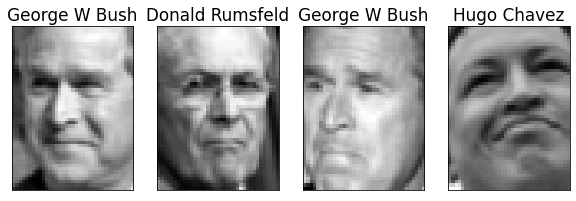

In [4]:
def plt_face(x):
    h = 50
    w = 37
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

## Computing the PCA via an SVD

First, we subtract the mean from the data set.

In [5]:
npix = h*w
Xmean = np.mean(X,0)
Xs = X - Xmean[None,:]

Then, we compute an SVD.  Note that in python the SVD returns `V` not `V.T`.  Also, you should include the `full_matrices` option to get the *economy* SVD

In [6]:
U,S,Vtr = np.linalg.svd(Xs, full_matrices=False)

We can plot the proportion of variance as a function of the number of PCs

Text(0, 0.5, 'PoV')

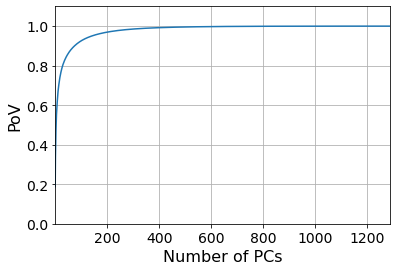

In [7]:
lam = S**2
PoV = np.cumsum(lam)/np.sum(lam)

plt.plot(PoV)
plt.grid()
plt.axis([1,n_samples,0, 1.1])
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('PoV', fontsize=16)

We can now get the PC decomposition of the data:

    X ~= Xhat = Xmean + Z.dot( W )
    
The terms

*  `Z` is the coefficient of the samples on the data
*  `W` are the PC components

These can be computed from the SVD as follows.

In [8]:
nsamp = X.shape[0]
ncomp = 20
Z = U[:,:ncomp]*S[None,:ncomp]

## Computing the PCA with Skelarn PCA Method
We can also compute the PCA with `sklearn` built in method as follow

In [9]:
from sklearn.decomposition import PCA

# Construct the PCA object
pca = PCA(n_components=ncomp, 
          svd_solver='randomized', whiten=True)

# Fit the PCA components on the entire dataset
pca.fit(X)

PCA(n_components=20, svd_solver='randomized', whiten=True)

When the `whiten` option is set, the `sklearn` method produces *whitened* versions of the components.  Each component is scaled by the `sqrt(nsamp/S[j])` to make sure that the components have mean zero and unit variance.  We can see that the whitened components from the SVD match those from the `PCA`.  There may be a sign change.

In [10]:
Zwhiten = U[:,:ncomp]*np.sqrt(nsamp)
Zwhiten_pca = pca.transform(X)

# Print the coefficients for sample 0
print(Zwhiten_pca[0,:5])
print(Zwhiten[0,:5])

[ 0.13230944  0.14949058  0.5200683  -0.09500905 -0.8203601 ]
[-0.13236079 -0.14954892 -0.5202697   0.09504712 -0.8206788 ]


We can also compare the PC components.  Note that `pca.components_` match the components with PCA 

In [11]:
Vtr_pca = pca.components_
print(Vtr_pca[0,:5])
print(Vtr[0,:5])

[-0.00681694 -0.00736357 -0.00855025 -0.01002201 -0.01114255]
[0.00681695 0.00736358 0.00855025 0.01002201 0.01114255]


## Plotting Reconstructed Images from PCs

We now plot the PC reconstructions.  We can use the transforms from the sklearn PCA or the SVD.

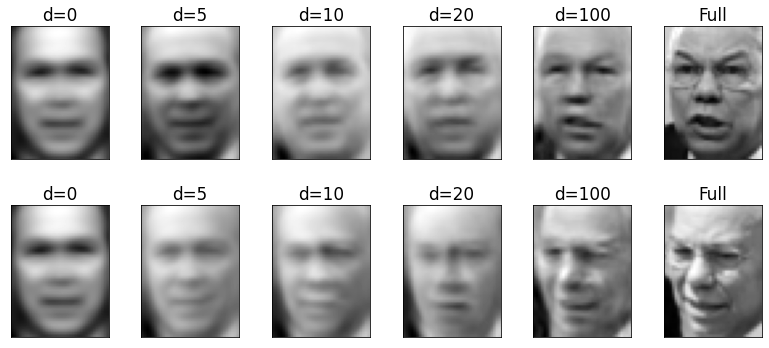

In [12]:
nplt = 2               # number of faces to plot
ds = [0,5,10,20,100]   # number of SVD approximations
use_pca = True         # True=Use sklearn reconstruction, else use SVD

if use_pca:
    # Construct the PCA object for the max number of coefficient
    dmax = np.max(ds)
    pca = PCA(n_components=dmax, svd_solver='randomized', whiten=True)
    
    # Fit and transform the data
    pca.fit(X)
    Z = pca.transform(X)
    

# Fit the PCA components on the entire dataset
pca.fit(X)

# Select random faces
inds = np.random.permutation(n_samples)
inds = inds[:nplt]
nd = len(ds)

# Set figure size
plt.figure(figsize=(1.8 * (nd+1), 2.4 * nplt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# Loop over figures
iplt = 0
for ind in inds:
    for d in ds:
        plt.subplot(nplt,nd+1,iplt+1)
        if use_pca:
            # Zero out coefficients after d.  
            # Note, we need to copy to not overwrite the coefficients
            Zd = np.copy(Z[ind,:])
            Zd[d:] = 0
            Xhati = pca.inverse_transform(Zd)
        else:
            # Reconstruct with SVD
            Xhati = (U[ind,:d]*S[None,:d]).dot(Vtr[:d,:]) + Xmean
            
        plt_face(Xhati)
        plt.title('d={0:d}'.format(d))
        iplt += 1
    
    # Plot the true face
    plt.subplot(nplt,nd+1,iplt+1)
    plt_face(X[ind,:])
    plt.title('Full')
    iplt += 1

Finally, we plot the PCs

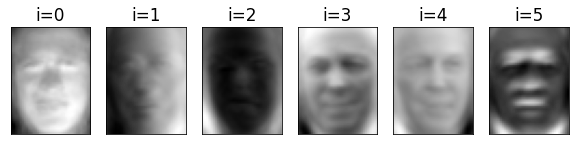

In [13]:
nplt = 6
plt.figure(figsize=(10, 20))
for i in range(nplt):
    plt.subplot(1,nplt,i+1)
    Vi = Vtr[i,:]
    plt_face(Vtr[i,:])
    plt.title('i={0:d}'.format(i))

## Face Classification using PCA Coefficients

We will use SVM to classify different faces based on PCA coefficients

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

We first split the data into training and test.  Given the relatively small amount of data, we will enable the "stratify" option to make sure that the training set has the same proportion of different classes as the total dataset.

In [15]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.25, stratify = y, random_state=43)

We now loop over different hyper-parameters to find the lowest test error:

* `npc` = number of PC components to use
* `gamma` = gamma value in the RBF kernel of the SVM.

We fix `C`, although this should be tested as well.

Note that for each set of parameters, we fit the PCA transformer.

In [16]:
npc_test = [25,50,75,100,200]
gam_test = [1e-3,4e-3,1e-2,1e-1]
C = 100
n0 = len(npc_test)
n1 = len(gam_test)
acc = np.zeros((n0,n1))
acc_max = 0

for i0, npc in enumerate(npc_test):
    
    # Fit PCA on the training data
    pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
    pca.fit(Xtr)

    # Transform the training and test
    Ztr = pca.transform(Xtr)
    Zts = pca.transform(Xts)
    
    for i1, gam in enumerate(gam_test):
                
        # Fiting on the transformed training data
        svc = SVC(C=C, kernel='rbf', gamma = gam)
        svc.fit(Ztr, ytr)
        
        # Predict on the test data
        yhat = svc.predict(Zts)
        
        # Compute the accuracy
        acc[i0,i1] = np.mean(yhat == yts)
        print('npc=%d gam=%12.4e acc=%12.4e' % (npc,gam,acc[i0,i1]))
        
        # Save the optimal parameters
        if acc[i0,i1] > acc_max:
            gam_opt = gam
            npc_opt = npc
            acc_max = acc[i0,i1]

npc=25 gam=  1.0000e-03 acc=  7.0186e-01
npc=25 gam=  4.0000e-03 acc=  6.9255e-01
npc=25 gam=  1.0000e-02 acc=  7.0186e-01
npc=25 gam=  1.0000e-01 acc=  6.9565e-01
npc=50 gam=  1.0000e-03 acc=  7.8571e-01
npc=50 gam=  4.0000e-03 acc=  7.8882e-01
npc=50 gam=  1.0000e-02 acc=  8.3851e-01
npc=50 gam=  1.0000e-01 acc=  4.6584e-01
npc=75 gam=  1.0000e-03 acc=  7.8882e-01
npc=75 gam=  4.0000e-03 acc=  8.2298e-01
npc=75 gam=  1.0000e-02 acc=  8.4472e-01
npc=75 gam=  1.0000e-01 acc=  4.1304e-01
npc=100 gam=  1.0000e-03 acc=  8.0124e-01
npc=100 gam=  4.0000e-03 acc=  8.4783e-01
npc=100 gam=  1.0000e-02 acc=  8.3230e-01
npc=100 gam=  1.0000e-01 acc=  4.1304e-01
npc=200 gam=  1.0000e-03 acc=  8.1677e-01
npc=200 gam=  4.0000e-03 acc=  8.3230e-01
npc=200 gam=  1.0000e-02 acc=  5.9938e-01
npc=200 gam=  1.0000e-01 acc=  4.1304e-01


We plot the accuracy as a function of the hyper-parameters.

Optimal num PCs = 75
Optimal gamma   = 0.010000


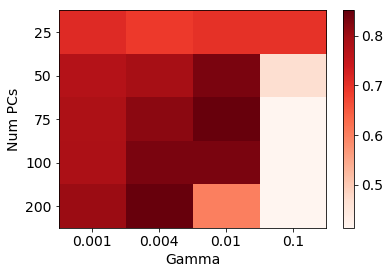

In [171]:
plt.imshow(acc, aspect='auto', cmap='Reds')
plt.xlabel('Gamma')
plt.ylabel('Num PCs')
plt.colorbar()

ax = plt.gca()
ax.set_xticks(np.arange(0,n1))
ax.set_xticklabels(gam_test)
ax.set_yticks(np.arange(0,n0))
_ = ax.set_yticklabels(npc_test)

print('Optimal num PCs = %d' % (npc_opt))
print('Optimal gamma   = %f' % (gam_opt))

Refit with the best classifier

In [17]:
npc = npc_opt
gam = gam_opt

# Fit the transformer
pca = PCA(n_components=npc, svd_solver='randomized', whiten=True)
pca.fit(Xtr)

# Transform the training and test
Ztr = pca.transform(Xtr)
Zts = pca.transform(Xts)

# Fiting on the transformed training data
svc = SVC(C=C, kernel='rbf', gamma = gam)
svc.fit(Ztr, ytr)

# Predict on the test data
yhat = svc.predict(Zts)

print(np.mean(yhat==yts))

0.8385093167701864


We can use following tools to print classification performance.

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(yts, yhat, target_names=target_names))
print("Confusion matrix on the test data")
print(confusion_matrix(yts, yhat, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.74      0.76        19
     Colin Powell       0.77      0.92      0.84        59
  Donald Rumsfeld       0.75      0.70      0.72        30
    George W Bush       0.89      0.89      0.89       133
Gerhard Schroeder       0.95      0.78      0.86        27
      Hugo Chavez       1.00      0.67      0.80        18
       Tony Blair       0.74      0.81      0.77        36

         accuracy                           0.84       322
        macro avg       0.84      0.79      0.81       322
     weighted avg       0.85      0.84      0.84       322

Confusion matrix on the test data
[[ 14   2   2   0   0   0   1]
 [  1  54   1   2   0   0   1]
 [  2   0  21   7   0   0   0]
 [  1   7   3 119   0   0   3]
 [  0   0   0   2  21   0   4]
 [  0   5   0   0   0  12   1]
 [  0   2   1   3   1   0  29]]


We can plot some correct classified images and misclassifed images in test set

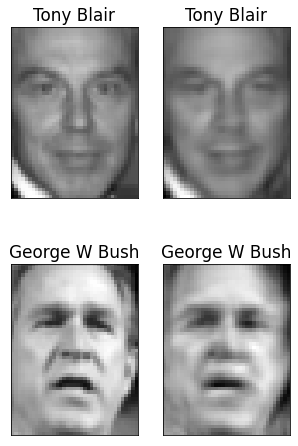

<Figure size 432x288 with 0 Axes>

In [19]:
correct_index = np.where(yhat==yts)[0][:2]
correct_origin = Xts[correct_index, :]
correct_pca = pca.inverse_transform(Zts[correct_index,:])
plt.figure(figsize=(5, 8))
for i in range(2):
    plt.subplot(2,2,2*i+1)
    plt_face(correct_origin[i,:])
    plt.title(target_names[yts[correct_index[i]]])
    
    plt.subplot(2,2,2*i+2)
    plt_face(correct_pca[i,:])
    plt.title(target_names[yhat[correct_index[i]]])
plt.show()
plt.tight_layout()

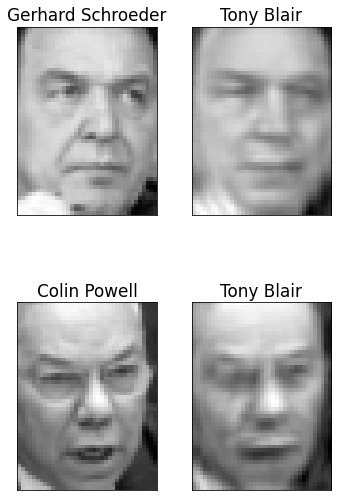

In [20]:
wrong_index = np.where(yhat!=yts)[0][:2]
wrong_origin = Xts[wrong_index, :]
wrong_pca = pca.inverse_transform(Zts[wrong_index,:])
plt.figure(figsize=(5, 8))
for i in range(2):
    plt.subplot(2,2,2*i+1)
    plt_face(wrong_origin[i,:])
    plt.title(target_names[yts[wrong_index[i]]])
    
    plt.subplot(2,2,2*i+2)
    plt_face(wrong_pca[i,:])
    plt.title(target_names[yhat[wrong_index[i]]])
    
plt.tight_layout()
plt.show()

We see that the failure cases may be caused by the pose difference of the test data from the majority of the training data.